<a href="https://colab.research.google.com/github/Prakruthir12/Flower-recongnition-Pytorch/blob/main/Flower_recongnition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Identifying Flower Species using Deep Learning and PyTorch**

1. Pick a dataset
2. Download the dataset
3. Import the dataset using Pytorch
4. Prepare the dataset for training
5. Move the dataset to the GPU
6. Define a neural networks
7. Train the model
8. Make predictions on sample images Iterate on it with different networks & hyperparameters

**Download the dataset from kaggle**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prakruthir","key":"908c35eb0662a9da2986f1dd27e522d9"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          23504        653  1.0              
mauryansshivam/netflix-ott-revenue-and-subscribers-csv-file           Netflix OTT Revenue and Subscribers (CSV File)        2KB  2023-05-13 17:40:23           1374         33  1.0              
darshanprabhu09/stock-prices-for                                      Stock prices of Amazon , Microsoft , Google, Apple   85KB  2023-05-16 15:17:16           1250         34  1.0              
fatihb/coffee-quality-data-cqi

In [ ]:
import shutil
import os

if os.path.exists('./flower'):
  shutil.rmtree('./flower')

In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition

flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir flower

In [ ]:
! unzip flowers-recognition.zip -d flower

Archive:  flowers-recognition.zip
  inflating: flower/flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flower/flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flower/flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flower/flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flower/flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flower/flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flower/flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flower/flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flower/flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flower/flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flower/flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flower/flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flower/flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flower/flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flower/flowers/daisy/10555749515_13a12a026e.jpg  
  inflating:

In [ ]:
import os

In [ ]:
data = './flower/flowers'

In [ ]:
os.listdir(data)

['rose', 'daisy', 'sunflower', 'tulip', 'dandelion']

In [ ]:
for cls in os.listdir(data):
  print(cls, ':', len(os.listdir(data + '/' +cls)))

rose : 784
daisy : 764
sunflower : 733
tulip : 984
dandelion : 1052


**Import the dataset into pytorch**

Use `ImageFolder` class from torchvision

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data)

In [ ]:
len(dataset)

4317

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F6285410280>, 0)

In [ ]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

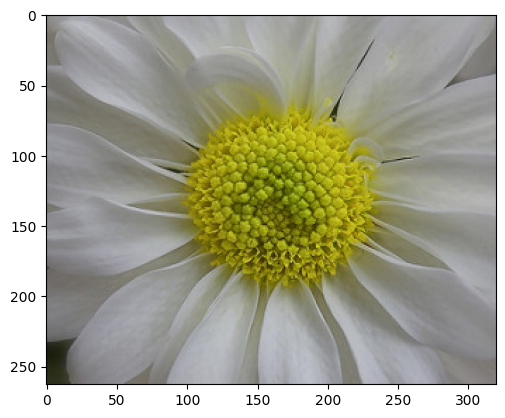

In [ ]:
img, label = dataset[0]
plt.imshow(img)

In [ ]:
import torchvision.transforms as tt

dataset = ImageFolder(data, tt.Compose([tt.Resize(224),
                                        tt.RandomCrop(244),
                                        tt.ToTensor()]))

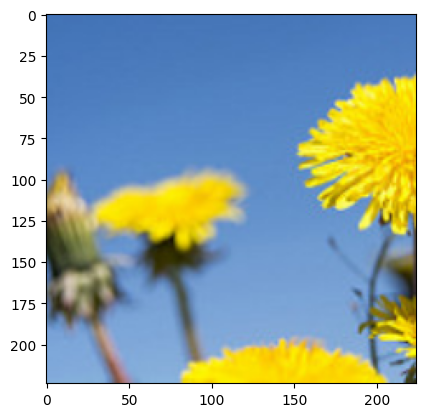

In [ ]:
img, label = dataset[1000]
plt.imshow(img.permute(1,2,0))

**Split data into validation and traning dataset**

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [ ]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

**We Can Create data loaders for training and validation, to load the data in batches**

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


We can look at batches Of images from the dataset using the `make_grid` method from `torchvision` . Each
the following code is run. we get a different bach, Since the sampler shumes the indices before creating batches.

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

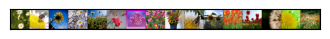

In [ ]:
show_batch(train_dl)

**Utility functions & classes**

To seamlessly use a GPU. if one is available, we define a couple of helper functions ( `get_default_device` &
`to_device` ) and a helper class DeviceDataLoader to move model & data tothe GPU as required.

In [ ]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
img, label = dataset[0]
img.shape

torch.Size([3, 224, 224])

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

**Model and Training Utilties**

Defining the model by extending `ImageClassificationBase` class which contains helper methods for traning & validation

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We will define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its On the validation Set.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    "Evaluates the model's performance on the validation set"
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

**Model**

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: batch_size x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) 
        self.conv2 = conv_block(64, 16, pool=True) 
        self.res1 = nn.Sequential(conv_block(16, 16), 
                                  conv_block(16, 16))
        
        self.conv3 = conv_block(16, 32, pool=True)
        self.conv4 = conv_block(32, 64, pool=True)  
        self.res2 = nn.Sequential(conv_block(64, 64), 
                                  conv_block(64, 64)) 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),  
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(64, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model

In [ ]:
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device',images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  break

images.shape torch.Size([16, 3, 224, 224])
images.device cuda:0
preds.shape torch.Size([16, 5])


**Training the model**

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6078779697418213, 'val_acc': 0.18996913731098175}]

In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.3708, val_loss: 1.0364, val_acc: 0.5684
Epoch [1], train_loss: 1.0901, val_loss: 0.8730, val_acc: 0.6448
Epoch [2], train_loss: 1.0151, val_loss: 0.8812, val_acc: 0.6451
Epoch [3], train_loss: 0.9256, val_loss: 0.8734, val_acc: 0.6750
Epoch [4], train_loss: 0.8691, val_loss: 0.7864, val_acc: 0.6986


In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8490, val_loss: 0.7313, val_acc: 0.7238
Epoch [1], train_loss: 0.8230, val_loss: 0.6984, val_acc: 0.7353
Epoch [2], train_loss: 0.7603, val_loss: 0.6799, val_acc: 0.7775
Epoch [3], train_loss: 0.7331, val_loss: 0.6950, val_acc: 0.7563
Epoch [4], train_loss: 0.6982, val_loss: 0.6949, val_acc: 0.7309


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.5820, val_loss: 0.5586, val_acc: 0.8029
Epoch [1], train_loss: 0.5634, val_loss: 0.5523, val_acc: 0.8076
Epoch [2], train_loss: 0.5304, val_loss: 0.5521, val_acc: 0.8099
Epoch [3], train_loss: 0.5559, val_loss: 0.5413, val_acc: 0.8029
Epoch [4], train_loss: 0.5342, val_loss: 0.5219, val_acc: 0.8099


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.5177, val_loss: 0.5008, val_acc: 0.8284
Epoch [1], train_loss: 0.5102, val_loss: 0.5223, val_acc: 0.8145
Epoch [2], train_loss: 0.5040, val_loss: 0.5132, val_acc: 0.8261
Epoch [3], train_loss: 0.5157, val_loss: 0.5232, val_acc: 0.8307
Epoch [4], train_loss: 0.5209, val_loss: 0.5234, val_acc: 0.8168


**Lets plot the valdation set accuracies to study how the model improves over time.**

In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs No. of epochs');

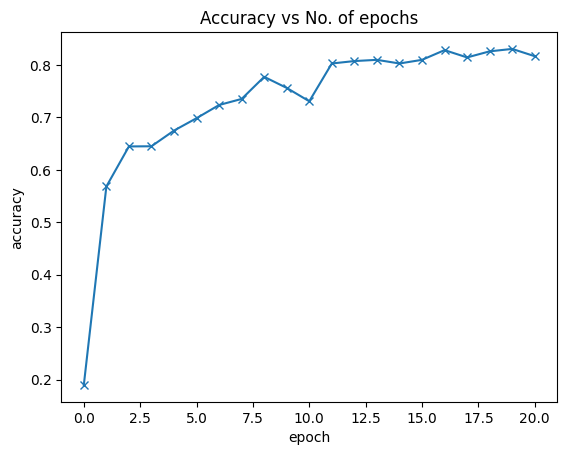

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs')

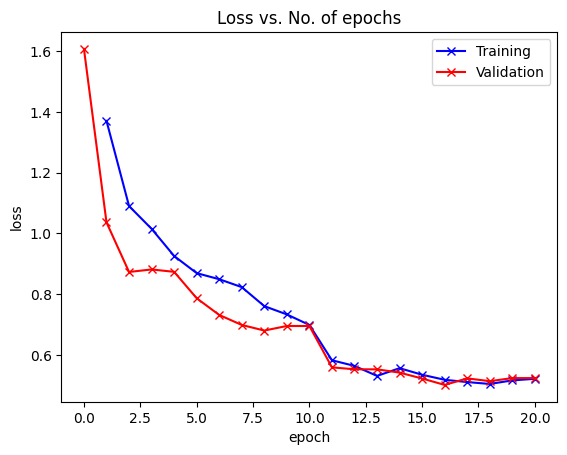

In [ ]:
plot_losses(history)

**Record the results**

In [ ]:
history[-1]

{'val_loss': 0.5233585834503174,
 'val_acc': 0.8168209791183472,
 'train_loss': 0.5208791494369507}

image_size = 64

batch_size=128 

lrs=[0.001, 0.001, 1e-4, 1e-4],

opt=['Adam', 'Adam', 'Adam', 'SGD']


**Test with Individual Images**

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: dandelion
Prediction: dandelion


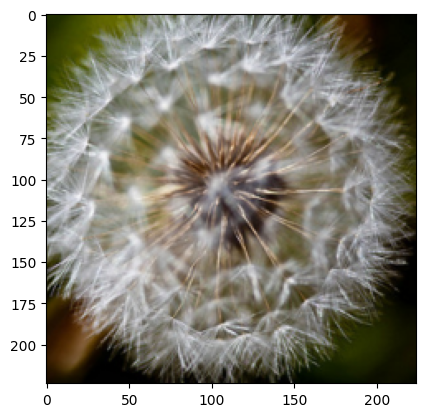

In [ ]:
show_image_prediction(*valid_ds[200])

Target: daisy
Prediction: daisy


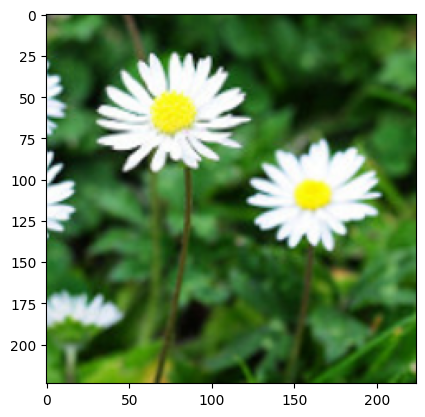

In [ ]:
show_image_prediction(*valid_ds[250])

Target: rose
Prediction: rose


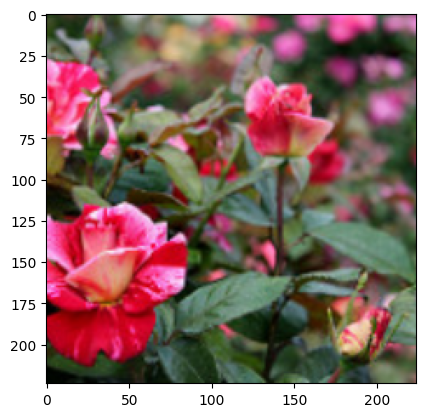

In [ ]:
show_image_prediction(*valid_ds[58])

Target: daisy
Prediction: daisy


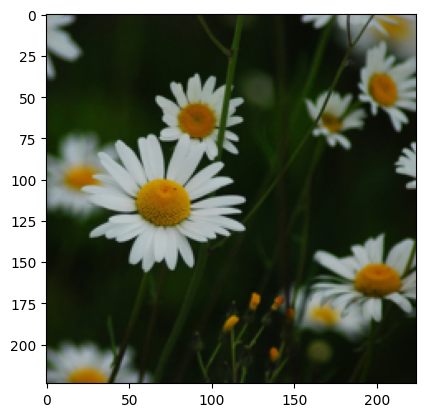

In [ ]:
show_image_prediction(*valid_ds[189])